In [ ]:
import os
import cv2
import numpy as np

import datetime as dt

import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from keras import Model
from keras.applications import vgg16
from keras.preprocessing import image as image_utils

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import file_locations

## Import Pretrained VGG16

In [2]:
#Take pretrained model
base_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [3]:
#finetuning model setup (might want to take those 2 fc's.. this is a lot of params)

K.set_learning_phase(0)

base_model = vgg16.VGG16(weights='imagenet', include_top=True, pooling = None, classes=1000, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-2].output
predictions = Dense(2, name='predictions', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x) 
model = Model(inputs=base_model.input, outputs=predictions)

K.set_learning_phase(1)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Quick ImageNet Check

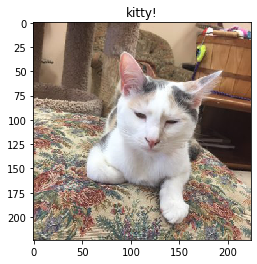

In [4]:
image = image_utils.load_img("./data/kitty.jpg",target_size=(224, 224))
plt.imshow(image)
plt.title('kitty!')
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [6]:
preds = base_model.predict(x)
decoded_preds = vgg16.decode_predictions(preds)
print('Predicted:', decoded_preds)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node block1_conv1_1/convolution}}]]
	 [[{{node predictions_1/Softmax}}]]

## IMDB-WIKI Dataset - Gender

In [ ]:
# grab images from database
image = image_utils.load_img(file_locations.PATH_TO_IMDB_GENDER+'0/2452600_1967-08-22_2013.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=vgg16.preprocess_input, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

In [ ]:
BS = 32

train_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_GENDER, class_mode = 'categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='training', seed=1337)
val_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_GENDER, class_mode='categorical', batch_size=BS, target_size=(224,224), shuffle=False, subset='validation')

## Model Retraining

In [ ]:
#callbacks to use during trinaing
cpcb = keras.callbacks.ModelCheckpoint(
    './checkpoints_vgg16/weights.{}.hdf5'.format(dt.datetime.now().strftime("%Y.%m.%d-%H%M")+"-streamline"), 
    monitor='val_categorical_accuracy', verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [ ]:
#choice of optimizer
mx_opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
model.compile(optimizer = mx_opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy']
             )

In [ ]:
0.05*train_it.samples // BS

In [ ]:
#training (note:only using a quarter of samples for now)
history = model.fit_generator(
    train_it,
    steps_per_epoch = 0.25*train_it.samples // BS,
    validation_data = val_it, 
    validation_steps = 0.25*train_it.samples // BS,
    epochs = 1,
    callbacks = [ cpcb, reduce_lr ]
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["train","val"])
plt.show()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(["train","val"])
plt.show()